# Homework 3: Retrieval Ensemble

Ad Soyad: Önder Görmez  
Öğrenci No: 21501035


# Logger Kullanımı

- Oluşturulan kod içerisinde loglama işlemleri için `logging` kütüphanesi kullanılmıştır.
- Böylelikle geliştirme aşamasında debug için koyulan kodların çıktılarına bakılarak hata ayıklama işlemleri yapılabilir. Bu kodların çıktıları rapor sunulurken kaldırılacaktır.


In [1]:
import logging
import logging.config
import yaml
import textwrap


class CustomFormatter(logging.Formatter):

    def format(self, record):
        wrapped_message = super().format(record)

        # wrap the log messages to 120 characters to better fit the screen
        if (len(wrapped_message) > 120):
            wrapped_message = "\n".join(textwrap.wrap(wrapped_message, width=120))

            # indent the wrapped lines but not the first line
            first_line, rest = wrapped_message.split('\n', 1)
            wrapped_message = first_line + '\n' + textwrap.indent(rest, ' ' * 4) + '\n'

        return wrapped_message


HOMEWORK_DIR = '/Users/ondergormez/Repos/BLM5109_Collective_Learning/02-Homeworks/Homework3/'
LOGGER_CONFIG_FILE = HOMEWORK_DIR + 'logger_config.yaml'

# Load the YAML configuration
with open('logger_config.yaml', 'r') as file:
    config = yaml.safe_load(file.read())
    logging.config.dictConfig(config)

# Apply the custom formatter to the selected handler
logger = logging.getLogger("default_logger")
for handler in logger.handlers:
    if isinstance(handler, logging.StreamHandler):
        handler.setFormatter(CustomFormatter(handler.formatter._fmt, datefmt=handler.formatter.datefmt))

# TODO: Set the log level to INFO
logger.setLevel(logging.INFO)


logger.debug("This is a debug message that will be wrapped after 140 characters. " * 10)
logger.info("Logging is configured successfully.")

[INFO] [2024-12-20T01:16:29.840Z] Logging is configured successfully.


# Dataset'in Yüklenmesi

https://huggingface.co/datasets/merve/turkish_instructions adresinde bulunan dosyadaki talimat ve girişi birleştirerek soruları, çıktıyı ise sorunun cevabı olarak kullanacağız.

Rastgele 2000 soru ve cevabını seçeceğiz ve bu 2000 örnek üzerinden ödevimizi gerçekleştireceğiz.


In [2]:
import pandas as pd

FILE_PATH = HOMEWORK_DIR + 'instructions.csv'

raw_data_df = pd.read_csv(FILE_PATH, sep=',')

logger.info("Columns of the raw dataframe: " + str(raw_data_df.columns))

# Satır isimlerini düzelt
raw_data_df = raw_data_df.rename(columns={'Unnamed: 0': 'index', ' giriş': 'giriş', ' çıktı': 'çıktı'})
logger.info("Renamed columns of the raw dataframe: " + str(raw_data_df.columns))

logger.info("Shape of the dataframe: " + str(raw_data_df.shape))
raw_data_df.head()

[INFO] [2024-12-20T01:16:30.322Z] Columns of the raw dataframe: Index(['Unnamed: 0', 'talimat', ' giriş', ' çıktı'],
    dtype='object')

[INFO] [2024-12-20T01:16:30.324Z] Renamed columns of the raw dataframe: Index(['index', 'talimat', 'giriş', 'çıktı'],
    dtype='object')

[INFO] [2024-12-20T01:16:30.324Z] Shape of the dataframe: (51563, 4)


,index,talimat,giriş,çıktı
0,0,Aşağıdaki bağlamda orijinal bir şey söyleyin:...,NaN,Ekibe katkıda bulunmaya başlamak ve bu alanda...
1,1,Aşağıdaki makale için bir başlık önerin: Bu m...,NaN,"""Dijital İletişimin Gücü: İnternet İş Ortamın..."
2,2,Şu konuyla ilgili 5 anahtar kelimeden oluşan ...,NaN,1. Karbon emisyonları 2. Yenilenebilir enerji...
3,3,Bu cümleyi pasiften aktife değiştirin: Yeni p...,NaN,Belediye başkanı yeni politikayı açıkladı.
4,4,Aşağıdaki fenomeni tanımlayan üç bilimsel teri...,NaN,"Yerçekimi kuvveti, Newton'un evrensel çekim y..."


## NaN Değerlerin Kaldırılması

Yukarıda görüldüğü gibi giriş kolonu için bazı satrılarda değer olmadığı görülmektedir.

- Eğitim setimizi 2000 veri ile sınırlayacağımız için giriş bilgiler NaN olanları dataset üzerinden siliyoruz.
- Bu satırları yok sayarak diğer satırlar ile işlem yapıp daha net sonuçlar elde edebiliriz.


In [3]:
# NaN olan satırları siliyoruz
raw_data_df = raw_data_df.dropna()

logger.info("Shape of the dataframe: " + str(raw_data_df.shape))
raw_data_df.head()

[INFO] [2024-12-20T01:16:30.335Z] Shape of the dataframe: (19088, 4)


,index,talimat,giriş,çıktı
11,11,Listeden herhangi üç kelime seçin.,"elma, muz, portakal","elma, muz, portakal"
24,24,"Aşağıdaki cümleyi düzenleyin: ""Köprüyü inşa e...","""Köprüyü inşa etmek için matkaplar ve kırıcıl...","""Köprüyü inşa etmek için matkaplar ve matkapla..."
28,28,Aşağıdaki 8 mısralık şiirin kafiye şemasını t...,"""Geçen günlerde, çok uzaklarda kabaran dalgal...",Şiirin kafiye düzeni AABBCCDD'dir. Şiirin dize...
37,37,Hollandaca'dan İngilizce'ye çeviri.,Büyük bir muştaya sahip olmak.,Ona kocaman sarıldı.
43,43,Düzeltmek için bu cümleyi düzenleyin: Elmalar...,Elma en sağlıklı besindir,Elma en sağlıklı besindir.


## Rastgele 2000 Örneğin Seçilmesi

Rastgele 2000 örnek aşağıdaki şekilde seçilir.

- `random_state` parametresi kullanılarak her çalıştırıldığında aynı örneklerin seçilmesi sağlanır.
- Böylelikle model eğitilirken ve performans ölçümleri yapılırken aynı veri seti üzerinden işlem yapılır.


In [4]:
# TODO: Hızlı embedding çıkarabilmek için örnek sayısını azalttık. Daha sonra 2000 örnek üzerinde çalışacağız.
# number_of_samples = 50
number_of_samples = 2000
# Select a random sample of 2000 questions and answers
sample_df = raw_data_df.sample(n=number_of_samples, random_state=865)

logger.info("Shape of the sampled dataframe: " + str(sample_df.shape))
sample_df.head()

[INFO] [2024-12-20T01:16:30.341Z] Shape of the sampled dataframe: (2000, 4)


,index,talimat,giriş,çıktı
19512,19512,"Bir cümle verildiğinde, üçüncü ve beşinci kel...",Bu rastgele bir cümle.,Bu bir cümle.
24904,24904,Cümledeki gramer hatalarını düzeltin.,Malzeme almak için dükkana geldi.,Malzeme almak için dükkana geldi.
807,807,Aşağıdaki cümleyi aynı anlamda fakat başka bi...,Daha çok ağaç dikmeliyiz.,Yetiştirdiğimiz ağaç sayısını artıralım.
48133,48133,"Bir makale verildiğinde, içeriği bir cümleyle...","Bu makale depresyonun nedenleri, belirtileri ...","Depresyon, kalıcı üzüntü, değersizlik duygusu ..."
30813,30813,Bağlamı bir alaycı tonla yeniden yazın.,Çağrımıza katıldığınız için teşekkür ederiz.,"Oh, seni bu görüşmede görmek ne büyük zevk."


## Soru ve Cevapların Oluşturulması


Seçilen 2000 örnek için soru ve cevaplar aşağıdaki şekilde oluşturulur.

- Talimat ve giriş birleştirilerek sorular oluşturulur.
- Çıktı ise sorunun cevabı olarak kabul edilir.


In [5]:
data_df = pd.DataFrame()
data_df['index'] = sample_df['index']
data_df['soru'] = sample_df['talimat'] + " " + sample_df['giriş']
data_df['cevap'] = sample_df['çıktı']

logger.info("Shape of the sampled dataframe: " + str(data_df.shape))
data_df.head()

# display(data_df)

[INFO] [2024-12-20T01:16:30.347Z] Shape of the sampled dataframe: (2000, 3)


,index,soru,cevap
19512,19512,"Bir cümle verildiğinde, üçüncü ve beşinci kel...",Bu bir cümle.
24904,24904,Cümledeki gramer hatalarını düzeltin. Malzem...,Malzeme almak için dükkana geldi.
807,807,Aşağıdaki cümleyi aynı anlamda fakat başka bi...,Yetiştirdiğimiz ağaç sayısını artıralım.
48133,48133,"Bir makale verildiğinde, içeriği bir cümleyle...","Depresyon, kalıcı üzüntü, değersizlik duygusu ..."
30813,30813,Bağlamı bir alaycı tonla yeniden yazın. Çağr...,"Oh, seni bu görüşmede görmek ne büyük zevk."


## Temsil Yöntemlerinin Tanımlanması

Aşağıda listesi verilen temsil yöntemleri üzerinde çalışma yapılarak en iyi sonuç veren yöntem gözlemlenecektir. Bu yöntemlerin birleştirilmesi ile oluşan yöntemin başarısı ile kıyaslanacaktır.

- all-MiniLM-L12-v2
- all-mpnet-base-v2
- ytu-ce-cosmos/turkish-colbert
- Multilingual-E5-large-instruct
- bert-base-turkish-cased


## all-MiniLM-L12-v2

https://huggingface.co/sentence-transformers/all-MiniLM-L12-v2


In [6]:
from transformers import AutoTokenizer, AutoModel

tokenizer_minilm = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")
model_minilm = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")

/Users/ondergormez/Repos/python_3_12_2_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# all-mpnet-base-v2

https://huggingface.co/sentence-transformers/all-mpnet-base-v2

- It maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search.


In [7]:
tokenizer_mpnet = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
model_mpnet = AutoModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")

# ytu-ce-cosmos/turkish-colbert

https://huggingface.co/ytu-ce-cosmos/turkish-colbert


In [8]:
tokenizer_cosmos_colbert = AutoTokenizer.from_pretrained("ytu-ce-cosmos/turkish-colbert")
model_cosmos_colbert = AutoModel.from_pretrained("ytu-ce-cosmos/turkish-colbert")

## Multilingual-E5-large-instruct

https://huggingface.co/intfloat/multilingual-e5-large-instruct


In [9]:
tokenizer_multilingual_e5_large = AutoTokenizer.from_pretrained("intfloat/multilingual-e5-large-instruct")
model_multilingual_e5_large = AutoModel.from_pretrained("intfloat/multilingual-e5-large-instruct")

# dbmdz Turkish BERT model

https://huggingface.co/dbmdz/bert-base-turkish-cased


In [10]:
tokenizer_dbmdz_turkish_bert = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
model_dbmdz_turkish_bert = AutoModel.from_pretrained("dbmdz/bert-base-turkish-cased")

# Word Embeddings


In [11]:
import time
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F


def mean_pooling(model_output, attention_mask):
    # Mean Pooling - Take attention mask into account for correct averaging

    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


def generate_embeddings(texts, tokenizer, model):
    # Function to generate embeddings using a given model and tokenizer
    start_time = time.time()

    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
    logger.info("Shape of the model output: " + str(model_output[0].shape))

    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

    logger.info("Shape of the sentence embeddings: " + str(sentence_embeddings.shape))
    print()

    elapsed_time = time.time() - start_time

    return sentence_embeddings, elapsed_time

In [12]:
import pandas as pd

minilm_question_embeddings, minilm_question_time = generate_embeddings(
    data_df['soru'].tolist(), tokenizer_minilm, model_minilm)

minilm_answer_embeddings, minilm_answer_time = generate_embeddings(
    data_df['cevap'].tolist(), tokenizer_minilm, model_minilm)

[INFO] [2024-12-20T01:18:36.602Z] Shape of the model output: torch.Size([2000, 512, 384])
[INFO] [2024-12-20T01:18:36.802Z] Shape of the sentence embeddings: torch.Size([2000, 384])

[INFO] [2024-12-20T01:20:23.574Z] Shape of the model output: torch.Size([2000, 512, 384])
[INFO] [2024-12-20T01:20:23.762Z] Shape of the sentence embeddings: torch.Size([2000, 384])



In [13]:
mpnet_question_embeddings, mpnet_question_time = generate_embeddings(
    data_df['soru'].tolist(), tokenizer_mpnet, model_mpnet)

mpnet_answer_embeddings, mpnet_answer_time = generate_embeddings(
    data_df['cevap'].tolist(), tokenizer_mpnet, model_mpnet)

[INFO] [2024-12-20T03:21:42.119Z] Shape of the model output: torch.Size([2000, 512, 768])
[INFO] [2024-12-20T03:21:42.717Z] Shape of the sentence embeddings: torch.Size([2000, 768])

[INFO] [2024-12-20T03:51:45.712Z] Shape of the model output: torch.Size([2000, 512, 768])
[INFO] [2024-12-20T03:51:46.208Z] Shape of the sentence embeddings: torch.Size([2000, 768])



In [14]:
cosmos_colbert_question_embeddings, cosmos_colbert_question_time = generate_embeddings(
    data_df['soru'].tolist(), tokenizer_cosmos_colbert, model_cosmos_colbert)

cosmos_colbert_answer_embeddings, cosmos_colbert_answer_time = generate_embeddings(
    data_df['cevap'].tolist(), tokenizer_cosmos_colbert, model_cosmos_colbert)

[INFO] [2024-12-20T03:54:27.915Z] Shape of the model output: torch.Size([2000, 354, 768])
[INFO] [2024-12-20T03:54:28.307Z] Shape of the sentence embeddings: torch.Size([2000, 768])

[INFO] [2024-12-20T04:00:15.493Z] Shape of the model output: torch.Size([2000, 512, 768])
[INFO] [2024-12-20T04:00:15.974Z] Shape of the sentence embeddings: torch.Size([2000, 768])



In [15]:
multilingual_e5_large_question_embeddings, multilingual_e5_large_question_time = generate_embeddings(
    data_df['soru'].tolist(), tokenizer_multilingual_e5_large, model_multilingual_e5_large)

multilingual_e5_large_answer_embeddings, multilingual_e5_large_answer_time = generate_embeddings(
    data_df['cevap'].tolist(), tokenizer_multilingual_e5_large, model_multilingual_e5_large)

[INFO] [2024-12-20T04:24:23.573Z] Shape of the model output: torch.Size([2000, 446, 1024])
[INFO] [2024-12-20T04:24:24.216Z] Shape of the sentence embeddings: torch.Size([2000, 1024])

[INFO] [2024-12-20T05:45:58.734Z] Shape of the model output: torch.Size([2000, 512, 1024])
[INFO] [2024-12-20T05:45:59.471Z] Shape of the sentence embeddings: torch.Size([2000, 1024])



In [16]:
dbmdz_turkish_bert_question_embeddings, dbmdz_turkish_bert_question_time = generate_embeddings(
    data_df['soru'].tolist(), tokenizer_dbmdz_turkish_bert, model_dbmdz_turkish_bert)

dbmdz_turkish_bert_answer_embeddings, dbmdz_turkish_bert_answer_time = generate_embeddings(
    data_df['cevap'].tolist(), tokenizer_dbmdz_turkish_bert, model_dbmdz_turkish_bert)

[INFO] [2024-12-20T05:48:49.447Z] Shape of the model output: torch.Size([2000, 375, 768])
[INFO] [2024-12-20T05:48:49.862Z] Shape of the sentence embeddings: torch.Size([2000, 768])

[INFO] [2024-12-20T05:54:56.030Z] Shape of the model output: torch.Size([2000, 512, 768])
[INFO] [2024-12-20T05:54:56.529Z] Shape of the sentence embeddings: torch.Size([2000, 768])



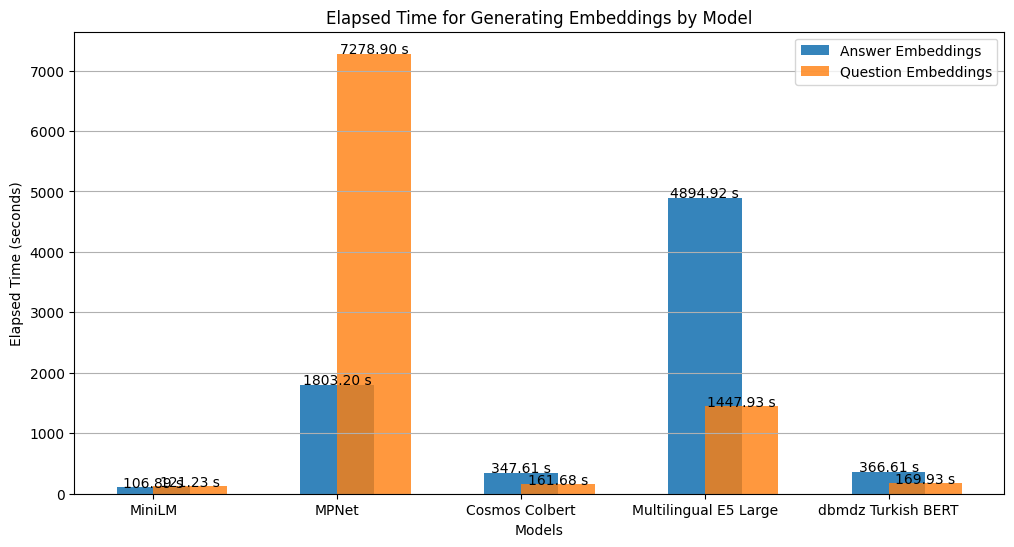

In [17]:
# Plot the elapsed time for each model
import matplotlib.pyplot as plt

models = ['MiniLM', 'MPNet', 'Cosmos Colbert', 'Multilingual E5 Large', 'dbmdz Turkish BERT']
question_times = [minilm_question_time, mpnet_question_time, cosmos_colbert_question_time,
                  multilingual_e5_large_question_time, dbmdz_turkish_bert_question_time]
answer_times = [minilm_answer_time, mpnet_answer_time, cosmos_colbert_answer_time,
                multilingual_e5_large_answer_time, dbmdz_turkish_bert_answer_time]


plt.figure(figsize=(12, 6))
plt.bar(models, answer_times, width=0.4, alpha=0.9, label='Answer Embeddings', align='center')
plt.bar(models, question_times, width=0.4, alpha=0.8, label='Question Embeddings', align='edge')

# Add seconds on top of the bars
for i in range(len(models)):
    plt.text(i + 0.2, question_times[i] + 0.1, f"{question_times[i]:.2f} s", ha='center')
    plt.text(i, answer_times[i] + 0.1, f"{answer_times[i]:.2f} s", ha='center')

plt.xlabel('Models')
plt.ylabel('Elapsed Time (seconds)')
plt.title('Elapsed Time for Generating Embeddings by Model')
plt.legend()
plt.grid(axis='y')
plt.show()

### Modellerin Embedding Süreleri

Yukarıdaki zaman grafiğinden görüldüğü gibi modellerin embedding süreleri aşağıdaki gibidir:

| Model                          | Question (sec.) | Question (min.) | Answer (sec.) | Answer Süresi (min.) |
| ------------------------------ | :-------------: | :-------------: | :-----------: | :------------------: |
| all-MiniLM-L12-v2              |       121       |        2        |      106      |          1           |
| all-mpnet-base-v2              |      7278       |       121       |     1803      |          30          |
| ytu-ce-cosmos/turkish-colbert  |       161       |        2        |      347      |          6           |
| Multilingual-E5-large-instruct |      1447       |       24        |     4894      |          81          |
| bert-base-turkish-cased        |       169       |        2        |      366      |          6           |
| **Total**                      |    **9176**     |     **153**     |   **7516**    |       **124**        |


## Soru ile Cevapların Tümü Arasınada Similarity Değerlerinin Hesabı

Her soru için tüm cevaplar ile similarity (benzerlik) değerleri hesaplanır.

- Bu hesaplama işlemi sonrasında her soru için 2000 adet cevap similarity si değeri elde edilir.
- Bu değerlerden **en büyük olan 5 tanesi (top 5)** seçilir. Diğer değerlerin önemi yoktur.


In [18]:
from sentence_transformers.util import cos_sim
import numpy as np


def get_similarites_and_rankings(question_embeddings, answer_embeddings):

    start_time = time.time()

    data_df_index = 0
    top5_indexes_and_similarities_dictionary = {}

    for question in question_embeddings:
        real_answer_index = data_df['index'].iloc[data_df_index]
        logger.debug("Trying to find the most similar answers to the question at index: " + str(real_answer_index))
        logger.debug("Real Question: " + data_df['soru'].iloc[data_df_index])
        logger.debug("Real Answer: " + data_df['cevap'].iloc[data_df_index])
        data_df_index += 1

        # Compute the similarity between the selected answer and all questions
        similarity_array = []
        for answer in answer_embeddings:
            similarity = cos_sim(answer, question).item()
            similarity_array.append(similarity)

        similarity_array = np.array(similarity_array)
        logger.debug(f"Shape of the similarity array for question {real_answer_index}: {len(similarity_array)}")

        top5_indexes = np.argsort(similarity_array)[-5:][::-1]
        predicted_top5_answer_indexes = data_df['index'].iloc[top5_indexes].values
        top5_similarities = similarity_array[top5_indexes]

        # top5_indexes_and_similarities_dictionary[real_answer_index] = (top5_indexes, top5_similarities)
        top5_indexes_and_similarities_dictionary[real_answer_index] = (predicted_top5_answer_indexes, top5_similarities)

        for i in range(5):
            logger.debug("Top " + str(i + 1) + " answer index: " + str(predicted_top5_answer_indexes[i]) +
                         ", similarity: " + str(top5_similarities[i]))
            # + ", cevap: " + data_df.iloc[top5_indexes[i]]['cevap'])

        # For debugging purposes
        # create top 5 dataframe
        # top5_df = pd.DataFrame(columns=data_df.columns)
        # for i in range(5):
        #     top5_df.loc[i] = data_df.iloc[top5_indexes[i]]
        #
        # display(top5_df)
        # print()
        # print()

    elapsed_time = time.time() - start_time
    logger.info("Elapsed time for finding the most similar answers: " + str(round(elapsed_time, 2)) + " seconds")

    return top5_indexes_and_similarities_dictionary

In [19]:
minilm_top5_indexes_and_similarities_dictionary = get_similarites_and_rankings(
    minilm_question_embeddings, minilm_answer_embeddings)

[INFO] [2024-12-20T05:55:48.258Z] Elapsed time for finding the most similar answers: 49.28 seconds


In [20]:
mpnet_top5_indexes_and_similarities_dictionary = get_similarites_and_rankings(
    mpnet_question_embeddings, mpnet_answer_embeddings)

[INFO] [2024-12-20T05:56:39.183Z] Elapsed time for finding the most similar answers: 50.92 seconds


In [21]:
cosmos_colbert_top5_indexes_and_similarities_dictionary = get_similarites_and_rankings(
    cosmos_colbert_question_embeddings, cosmos_colbert_answer_embeddings)

[INFO] [2024-12-20T05:57:30.202Z] Elapsed time for finding the most similar answers: 51.01 seconds


In [22]:
multilingual_e5_large_top5_indexes_and_similarities_dictionary = get_similarites_and_rankings(
    multilingual_e5_large_question_embeddings, multilingual_e5_large_answer_embeddings)

[INFO] [2024-12-20T05:58:21.759Z] Elapsed time for finding the most similar answers: 51.55 seconds


In [23]:
dbmdz_turkish_bert_top5_indexes_and_similarities_dictionary = get_similarites_and_rankings(
    dbmdz_turkish_bert_question_embeddings, dbmdz_turkish_bert_answer_embeddings)

[INFO] [2024-12-20T05:59:12.711Z] Elapsed time for finding the most similar answers: 50.94 seconds


# Elde Edilen Top 1 ve Top 5 Sonuçlar için Accuracy Hesabı


In [24]:
def calculate_accuracy(top5_indexes_and_similarities_dictionary):
    answer_index = 0
    top1_true_predictions = 0
    top5_true_predictions = 0

    for real_answer_index, (top5_indexes, top5_similarities) in top5_indexes_and_similarities_dictionary.items():
        answer_index += 1
        if real_answer_index == top5_indexes[0]:
            logger.debug("Question found in top 1!")
            top1_true_predictions += 1
            top5_true_predictions += 1
        elif real_answer_index in top5_indexes:
            logger.debug("Question found in top 5!")
            top5_true_predictions += 1
        else:
            logger.debug("Question not found in top 5!")

    # Calculate accuracy for top 1 and top 5 predictions
    top1_accuracy = (top1_true_predictions / answer_index) * 100
    top5_accuracy = (top5_true_predictions / answer_index) * 100

    logger.info("Top 1 accuracy: " + str(top1_accuracy))
    logger.info("Top 5 accuracy: " + str(top5_accuracy))

    return top1_accuracy, top5_accuracy

In [25]:
accuracy_dictionary = {}
accuracy_dictionary['minilm'] = calculate_accuracy(minilm_top5_indexes_and_similarities_dictionary)

[INFO] [2024-12-20T05:59:12.721Z] Top 1 accuracy: 30.95
[INFO] [2024-12-20T05:59:12.721Z] Top 5 accuracy: 40.699999999999996


In [26]:
accuracy_dictionary['mpnet'] = calculate_accuracy(mpnet_top5_indexes_and_similarities_dictionary)

[INFO] [2024-12-20T05:59:12.727Z] Top 1 accuracy: 23.549999999999997
[INFO] [2024-12-20T05:59:12.727Z] Top 5 accuracy: 33.2


In [27]:
accuracy_dictionary['cosmos_colbert'] = calculate_accuracy(cosmos_colbert_top5_indexes_and_similarities_dictionary)

[INFO] [2024-12-20T05:59:12.734Z] Top 1 accuracy: 36.25
[INFO] [2024-12-20T05:59:12.734Z] Top 5 accuracy: 47.949999999999996


In [28]:
accuracy_dictionary['multilingual_e5_large'] = calculate_accuracy(
    multilingual_e5_large_top5_indexes_and_similarities_dictionary)

[INFO] [2024-12-20T05:59:12.739Z] Top 1 accuracy: 72.6
[INFO] [2024-12-20T05:59:12.740Z] Top 5 accuracy: 85.0


In [29]:
accuracy_dictionary['dbmdz_turkish_bert'] = calculate_accuracy(
    dbmdz_turkish_bert_top5_indexes_and_similarities_dictionary)

[INFO] [2024-12-20T05:59:12.745Z] Top 1 accuracy: 27.55
[INFO] [2024-12-20T05:59:12.746Z] Top 5 accuracy: 37.85


Çıkan accuracy değerlerini görselleştirmek için aşağıdaki gibi çizdirelim.


[INFO] [2024-12-20T05:59:12.754Z] Accuracy dictionary: {'minilm': (30.95, 40.699999999999996), 'mpnet':
    (23.549999999999997, 33.2), 'cosmos_colbert': (36.25, 47.949999999999996), 'multilingual_e5_large': (72.6, 85.0),
    'dbmdz_turkish_bert': (27.55, 37.85)}



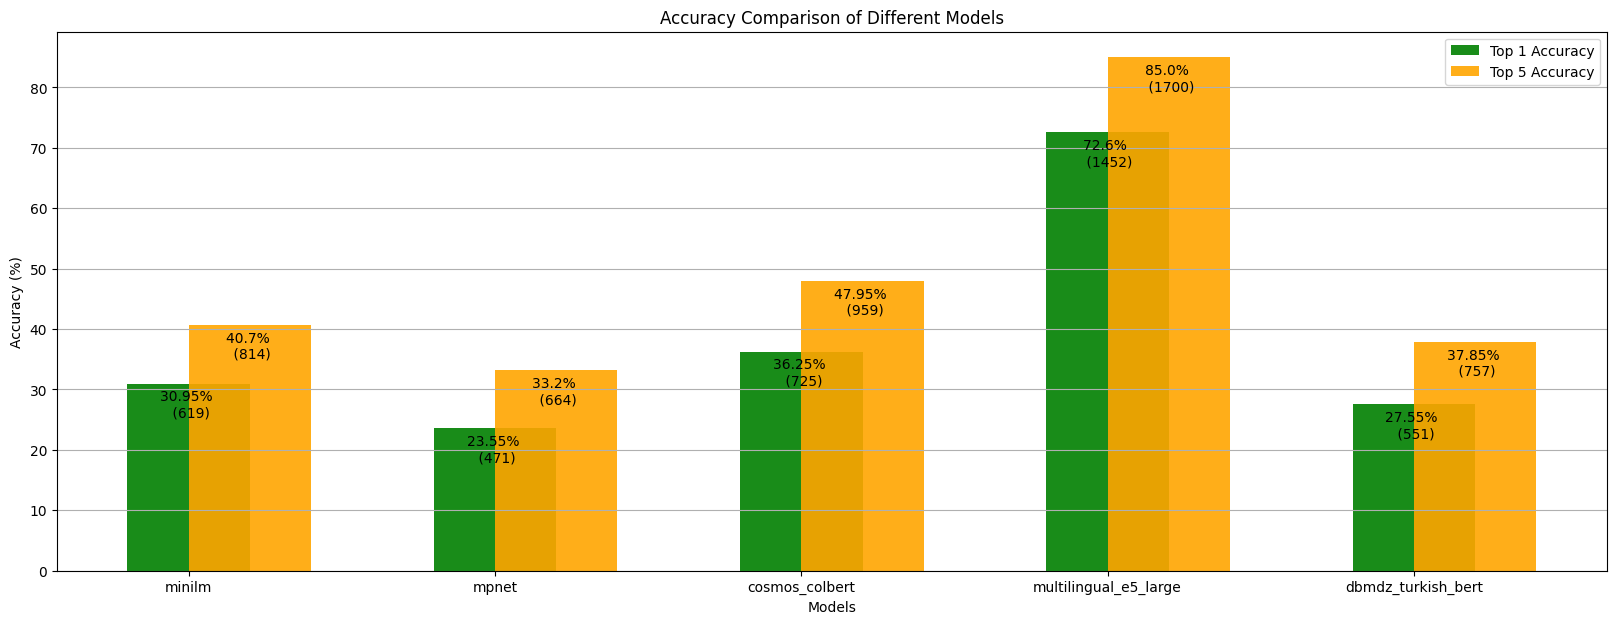

In [30]:
logger.info("Accuracy dictionary: " + str(accuracy_dictionary))


def plot_accuracies(accuracy_dictionary):
    import matplotlib.pyplot as plt

    models = list(accuracy_dictionary.keys())
    top1_accuracies = [accuracy[0] for accuracy in accuracy_dictionary.values()]
    top5_accuracies = [accuracy[1] for accuracy in accuracy_dictionary.values()]

    x = range(len(models))

    plt.figure(figsize=(20, 7))
    plt.bar(x, top1_accuracies, width=0.4, alpha=0.9, label='Top 1 Accuracy', color='green', align='center')
    plt.bar(x, top5_accuracies, width=0.4, alpha=0.9, label='Top 5 Accuracy', color='orange', align='edge')

    # Add percentages on top of the bars
    for i in range(len(models)):
        # round the accuracies to two decimal places
        total_top1_true_predictions = round((number_of_samples * top1_accuracies[i]) / 100)
        total_top5_true_predictions = round((number_of_samples * top5_accuracies[i]) / 100)

        plt.text(x[i], top1_accuracies[i] - 6,
                 str(round(top1_accuracies[i], 2)) + f'% \n ({total_top1_true_predictions})', ha='center', va='bottom')

        plt.text(x[i] + 0.2, top5_accuracies[i] - 6, str(round(top5_accuracies[i], 2)) +
                 f'% \n ({total_top5_true_predictions})', ha='center', va='bottom')

    plt.xlabel('Models')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Comparison of Different Models')
    plt.xticks(x, models)
    plt.legend()
    plt.grid(axis='y')

    plt.show()


plot_accuracies(accuracy_dictionary)

# Temsillerin / Benzerliklerin Birleştirilmesi


Her bir soru için 5 temsil yönteminden (modelden) top1 ve top5 leri al. Benzerlikleri birleştirerek tekil top1 ve top5 üret. (5 -> 1, 25 -> 5)


In [31]:
from collections import Counter


def get_ensemble_method1(indexes, similarities):
    # indexes dizisi içinde en çok tekrar eden index seçilir. Bu indexin similarity değeri de birlikte döndürülür.
    # Testleri ve açıklaması aşağıda verilmiştir.

    # Find the most common index in the array
    most_common_index = Counter(indexes).most_common(1)[0][0]
    most_common_index_count = Counter(indexes).most_common(1)[0][1]

    # Find the indexes with the most common count
    most_common_indexes = [index for index, count in Counter(indexes).items() if count == most_common_index_count]

    # If there is only one index with the most common count, return it
    if len(most_common_indexes) == 1:
        # find all indexes of the most common index and return the max similarity of this indexes
        highest_similarity = 0
        for i in range(len(indexes)):
            if indexes[i] == most_common_indexes[0]:
                if similarities[i] > highest_similarity:
                    highest_similarity = similarities[i]

        return most_common_indexes[0], highest_similarity

    # If there are multiple indexes with the most common count, find the one with the highest similarity
    highest_similarity_index = most_common_indexes[0]
    highest_similarity = 0

    for index in most_common_indexes:
        for i in range(len(indexes)):
            if indexes[i] == index:
                if similarities[i] > highest_similarity:
                    highest_similarity = similarities[i]
                    highest_similarity_index = index

    return highest_similarity_index, highest_similarity


# test için örnek data
# indexes dizisi içinde en çok tekrar eden index seçilir. Bu indexin similarity değeri de birlikte döndürülür.
# Birden fazla similarity olduğu için en büyük olanı seçilir.
top1_predicted_indexes = [1, 2, 3, 4, 3]
top1_similarities = [0.8, 0.9, 0.7, 0.6, 0.9]
most_common_index_and_similarity = get_ensemble_method1(top1_predicted_indexes, top1_similarities)
logger.info("Ensemble method 1 result: " + str(most_common_index_and_similarity))
assert most_common_index_and_similarity == (3, 0.9)

# eşit sayıda index değeri varsa, similarity değerine bakılır. En yüksek similarity değeri olan index seçilir.
top1_predicted_indexes = [1, 2, 3, 2, 3]
top1_similarities = [0.8, 0.5, 0.7, 0.91, 0.9]
most_common_index_and_similarity = get_ensemble_method1(top1_predicted_indexes, top1_similarities)
logger.info("Ensemble method 1 result: " + str(most_common_index_and_similarity))
assert most_common_index_and_similarity == (2, 0.91)

# eşit sayıda index değeri varsa, similarity de eşitse, en küçük index seçilir.
top1_predicted_indexes = [1, 2, 3, 2, 3]
top1_similarities = [0.8, 0.5, 0.7, 0.9, 0.9]
most_common_index_and_similarity = get_ensemble_method1(top1_predicted_indexes, top1_similarities)
logger.info("Ensemble method 1 result: " + str(most_common_index_and_similarity))
assert most_common_index_and_similarity == (2, 0.9)

[INFO] [2024-12-20T05:59:12.876Z] Ensemble method 1 result: (3, 0.9)
[INFO] [2024-12-20T05:59:12.877Z] Ensemble method 1 result: (2, 0.91)
[INFO] [2024-12-20T05:59:12.877Z] Ensemble method 1 result: (2, 0.9)


In [32]:
def get_ensemble_method2(indexes, similarities):
    # indexes dizisi içinde top1 ler arasında en yüksek similarity değerine sahip olan index seçilir.
    # Bu durum similarity değerinin en yüksek olduğu modelin ensemble başarısında ön plana çıkmasını sağlar.
    # Testlerden anlaşıldığı üzere bu "multilingual_e5_large" modelinin ön plana çıkmasını sağlamaktadır.
    # Testleri ve açıklaması aşağıda verilmiştir.

    highest_similarity_index = np.argmax(similarities)
    highest_similarity = similarities[highest_similarity_index]
    highest_similarity_index = indexes[highest_similarity_index]

    return highest_similarity_index, highest_similarity


# test için örnek data
# Index in kaç kere tekrar ettiği önemli değil. Top1 ler arasında en yüksek similarity değerine sahip olan index seçilir.
top1_predicted_indexes = [5, 5, 3, 4, 2]
top1_similarities = [0.8, 0.9, 0.7, 0.6, 0.91]
most_greater_similarity_index_and_similarity = get_ensemble_method2(top1_predicted_indexes, top1_similarities)
logger.info("Ensemble method 2 result: " + str(most_greater_similarity_index_and_similarity))
assert most_greater_similarity_index_and_similarity == (2, 0.91)

# eşit similarity değerine sahip indexler varsa, en küçük index seçilir.
top1_predicted_indexes = [5, 5, 3, 4, 2]
top1_similarities = [0.8, 0.9, 0.7, 0.9, 0.9]
most_greater_similarity_index_and_similarity = get_ensemble_method2(top1_predicted_indexes, top1_similarities)
logger.info("Ensemble method 3 result: " + str(most_greater_similarity_index_and_similarity))
assert most_greater_similarity_index_and_similarity == (5, 0.9)

[INFO] [2024-12-20T05:59:12.882Z] Ensemble method 2 result: (2, 0.91)
[INFO] [2024-12-20T05:59:12.882Z] Ensemble method 3 result: (5, 0.9)


In [33]:
def get_ensemble_method3(top25_indexes, top25_similarities):
    # indexes dizisi içinde top 25 index bulunur. Bunlardan en çok tekrar eden 5 index seçilerek top5 index oluşturulur.
    # Bu top5 indexler arasından da eşit sayıda olanlar varsa, en yüksek similarity değerine sahip olan index seçilir.
    # Testleri ve açıklaması aşağıda verilmiştir.

    selected_top5_indexes = []
    selected_top5_similarities = []

    # Find the most common index in the array
    top5_indexes = Counter(top25_indexes).most_common(5)

    for index, _ in top5_indexes:
        # find all indexes of the most common index and return the max similarity of this indexes
        highest_similarity = 0
        for i in range(len(top25_indexes)):
            if top25_indexes[i] == index:
                if top25_similarities[i] > highest_similarity:
                    highest_similarity = top25_similarities[i]

        selected_top5_indexes.append(index)
        selected_top5_similarities.append(highest_similarity)

    return selected_top5_indexes, selected_top5_similarities


# test için örnek data
# indexes dizisi içinde top 25 index bulunur. Bunlardan en çok tekrar eden 5 index seçilerek top5 index oluşturulur.
# indexlere ait similarity değerlerinden en yüksek olanlar seçilir.
top25_predicted_indexes = [5, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 1, 2, 3, 4]
top25_similarities = [0.8, 0.9, 0.7, 0.6, 0.91, 0.8, 0.9, 0.7, 0.6, 0.91,
                      0.8, 0.95, 0.7, 0.6, 0.91, 0.8, 0.9, 0.7, 0.6, 0.99, 0.8, 0.9, 0.7, 0.6]
selected_top5_indexes, selected_top5_similarities = get_ensemble_method3(top25_predicted_indexes, top25_similarities)
logger.info("Ensemble method 3 result, selected top 5 indexes: " + str(selected_top5_indexes))
logger.info("Ensemble method 3 result, selected top 5 similarities: " + str(selected_top5_similarities))
assert selected_top5_indexes == [9, 8, 7, 6, 5]
assert selected_top5_similarities == [0.99, 0.95, 0.9, 0.91, 0.9]

# eşit sayıda index değeri varsa, similarity değerine bakılır. En yüksek similarity değeri olan index seçilir.

top25_predicted_indexes = [5, 5, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 1, 2, 3, 4]
top25_similarities = [0.8, 0.95, 0.7, 0.6, 0.91, 0.8, 0.9, 0.7, 0.6, 0.91,
                      0.8, 0.95, 0.7, 0.6, 0.91, 0.8, 0.9, 0.7, 0.6, 0.99, 0.8, 0.9, 0.7, 0.6]
selected_top5_indexes, selected_top5_similarities = get_ensemble_method3(top25_predicted_indexes, top25_similarities)
logger.info("Ensemble method 3 result, selected top 5 indexes: " + str(selected_top5_indexes))
logger.info("Ensemble method 3 result, selected top 5 similarities: " + str(selected_top5_similarities))
assert selected_top5_indexes == [9, 8, 7, 5, 6]
# assert selected_top5_similarities == [0.99, 0.95, 0.9, 0.95, 0.7]

[INFO] [2024-12-20T05:59:12.887Z] Ensemble method 3 result, selected top 5 indexes: [9, 8, 7, 6, 5]
[INFO] [2024-12-20T05:59:12.888Z] Ensemble method 3 result, selected top 5 similarities: [0.99, 0.95, 0.9, 0.91, 0.9]
[INFO] [2024-12-20T05:59:12.888Z] Ensemble method 3 result, selected top 5 indexes: [9, 8, 7, 5, 6]
[INFO] [2024-12-20T05:59:12.888Z] Ensemble method 3 result, selected top 5 similarities: [0.91, 0.95, 0.91, 0.95, 0.7]


In [34]:
def get_ensemble_top5_indexes_and_similarities(top5_indexes_and_similarities_dictionaries, ensemble_method):
    combined_top5_indexes_and_similarities_dictionary = {}

    data_dictionary = {}

    # concatenate all top5 indexes and similarities. Result will be 25 indexes and similarities
    for model_name, (top5_indexes_and_similarities_dictionary) in top5_indexes_and_similarities_dictionaries.items():
        data_dictionary[model_name] = {}

        for real_answer_index, (top5_indexes, top5_similarities) in top5_indexes_and_similarities_dictionary.items():

            logger.debug(f"Model: {model_name}, Question: {real_answer_index}")
            logger.debug(f"Indexes: {top5_indexes}")
            logger.debug(f"Similarities: {top5_similarities}")
            logger.debug("")

            if real_answer_index not in combined_top5_indexes_and_similarities_dictionary:
                combined_top5_indexes_and_similarities_dictionary[real_answer_index] = (
                    [[] for _ in range(5)], [[] for _ in range(5)])

            for i in range(5):
                combined_top5_indexes_and_similarities_dictionary[real_answer_index][0][i].append(top5_indexes[i])
                combined_top5_indexes_and_similarities_dictionary[real_answer_index][1][i].append(top5_similarities[i])

    ensemble_top5_indexes_and_similarities = {}
    for real_answer_index, (indexes, similarities) in combined_top5_indexes_and_similarities_dictionary.items():

        logger.debug(f"Question: {real_answer_index}")
        logger.debug(f"Indexes: {indexes}, Similarities: {similarities}")

        selected_top5_indexes = []
        selected_top5_similarities = []

        for i in range(5):
            # Use get_ensemble_method1 to get the final top 5 combined indexes and similarities

            if ensemble_method == "method_1":
                selected_index, selected_similarity = get_ensemble_method1(indexes[i], similarities[i])
            elif ensemble_method == "method_2":
                selected_index, selected_similarity = get_ensemble_method2(indexes[i], similarities[i])
            else:
                raise ValueError("Invalid ensemble method: " + ensemble_method)

            selected_top5_indexes.append(selected_index)
            selected_top5_similarities.append(selected_similarity)

        ensemble_top5_indexes_and_similarities[real_answer_index] = (selected_top5_indexes, selected_top5_similarities)

        logger.debug(f"Question: {real_answer_index}")
        logger.debug(f"Ensemble: {ensemble_top5_indexes_and_similarities[real_answer_index]}")

    return ensemble_top5_indexes_and_similarities

In [35]:
# Örnek Çalışması aşağıdaki gibi:
#
# [INFO] [2024-12-18T22:46:14.989Z] Model: minilm, Question: 19512
# [INFO] [2024-12-18T22:46:14.990Z] Indexes: [31132 47052 21135 25299 15663]
# [INFO] [2024-12-18T22:46:14.991Z] Similarities: [0.65630591 0.59570324 0.5854063  0.57706159 0.55521119]
# [INFO] [2024-12-18T22:46:14.991Z]
#
# [INFO] [2024-12-18T22:46:15.083Z] Model: mpnet, Question: 19512
# [INFO] [2024-12-18T22:46:15.084Z] Indexes: [31132  6260 33525 25299 31457]
# [INFO] [2024-12-18T22:46:15.084Z] Similarities: [0.7082091  0.65570903 0.65200913 0.64118457 0.6273461 ]
# [INFO] [2024-12-18T22:46:15.084Z]
#
# [INFO] [2024-12-18T22:46:15.141Z] Model: cosmos_colbert, Question: 19512
# [INFO] [2024-12-18T22:46:15.142Z] Indexes: [31132 47052 19512 25299 48133]
# [INFO] [2024-12-18T22:46:15.142Z] Similarities: [0.61857104 0.60996813 0.60277951 0.60016912 0.59341037]
# [INFO] [2024-12-18T22:46:15.142Z]
#
# [INFO] [2024-12-18T22:46:15.201Z] Model: multilingual_e5_large, Question: 19512
# [INFO] [2024-12-18T22:46:15.201Z] Indexes: [19512 27183 23498  7324 33933]
# [INFO] [2024-12-18T22:46:15.201Z] Similarities: [0.87906605 0.87463862 0.8411001  0.84046221 0.8331328 ]
# [INFO] [2024-12-18T22:46:15.202Z]
#
# [INFO] [2024-12-18T22:46:15.333Z] Model: dbmdz_turkish_bert, Question: 19512
# [INFO] [2024-12-18T22:46:15.333Z] Indexes: [31132 15393 27183  6260  4639]
# [INFO] [2024-12-18T22:46:15.334Z] Similarities: [0.83515263 0.83198321 0.81642026 0.81306916 0.80721843]
# [INFO] [2024-12-18T22:46:15.334Z]
#
# [INFO] [2024-12-18T22:46:15.421Z] Question: 19512
# [INFO] [2024-12-18T22:46:15.421Z] Indexes: [[31132, 31132, 31132, 19512, 31132], [47052, 6260, 47052, 27183, 15393],
#     [21135, 33525, 19512, 23498, 27183], [25299, 25299, 25299, 7324, 6260], [15663, 31457, 48133, 33933, 4639]],
#     Similarities: [[0.6563059091567993, 0.7082090973854065, 0.6185710430145264, 0.8790660500526428, 0.8351526260375977],
#     [0.5957032442092896, 0.6557090282440186, 0.6099681258201599, 0.8746386170387268, 0.831983208656311],
#     [0.5854063034057617, 0.652009129524231, 0.6027795076370239, 0.8411000967025757, 0.8164202570915222],
#     [0.5770615935325623, 0.6411845684051514, 0.6001691222190857, 0.8404622077941895, 0.8130691647529602],
#     [0.5552111864089966, 0.6273460984230042, 0.5934103727340698, 0.833132803440094, 0.8072184324264526]]
#
# [INFO] [2024-12-18T22:46:15.421Z] Question: 19512
# [INFO] [2024-12-18T22:46:15.422Z] Ensemble: ([31132, 47052, 23498, 25299, 33933],
#                     [0.8351526260375977, 0.6099681258201599, 0.8411000967025757, 0.6411845684051514, 0.833132803440094])

In [36]:
def get_ensemble_top5_indexes_and_similarities_2(top5_indexes_and_similarities_dictionaries, ensemble_method):

    combined_top25_indexes_and_similarities_dictionary = {}
    ensemble_top5_indexes_and_similarities_dictionary = {}

    top25_indexes = []
    top25_similarities = []

    if ensemble_method != "method_3":
        raise ValueError("Invalid ensemble method: " + ensemble_method)

    # concatenate all top5 indexes and similarities. Result will be 25 indexes and similarities
    for model_name, (top5_indexes_and_similarities_dictionary) in top5_indexes_and_similarities_dictionaries.items():
        for real_answer_index, (top5_indexes, top5_similarities) in top5_indexes_and_similarities_dictionary.items():

            logger.debug(f"Model: {model_name}, Question: {real_answer_index}")
            logger.debug(f"Indexes: {top5_indexes}")
            logger.debug(f"Similarities: {top5_similarities}")
            logger.debug("")

            if real_answer_index not in combined_top25_indexes_and_similarities_dictionary:
                combined_top25_indexes_and_similarities_dictionary[real_answer_index] = ([], [])

            combined_top25_indexes_and_similarities_dictionary[real_answer_index][0].extend(top5_indexes)
            combined_top25_indexes_and_similarities_dictionary[real_answer_index][1].extend(top5_similarities)

    for real_answer_index, (top25_indexes, top25_similarities) in combined_top25_indexes_and_similarities_dictionary.items():
        selected_top5_indexes, selected_top5_similarities = get_ensemble_method3(top25_indexes, top25_similarities)
        ensemble_top5_indexes_and_similarities_dictionary[real_answer_index] = (
            selected_top5_indexes, selected_top5_similarities)

        logger.debug(f"Question: {real_answer_index}")
        logger.debug(f"Ensemble: {ensemble_top5_indexes_and_similarities_dictionary[real_answer_index]}")

    return ensemble_top5_indexes_and_similarities_dictionary

In [ ]:
top5_indexes_and_similarities_dictionaries = {'minilm': minilm_top5_indexes_and_similarities_dictionary,
                                              'mpnet': mpnet_top5_indexes_and_similarities_dictionary,
                                              'cosmos_colbert': cosmos_colbert_top5_indexes_and_similarities_dictionary,
                                              'multilingual_e5_large': multilingual_e5_large_top5_indexes_and_similarities_dictionary,
                                              'dbmdz_turkish_bert': dbmdz_turkish_bert_top5_indexes_and_similarities_dictionary
                                              }

ensemble_top5_indexes_and_similarities_dictionary_method_1 = get_ensemble_top5_indexes_and_similarities(
    top5_indexes_and_similarities_dictionaries, ensemble_method="method_1")

In [ ]:
ensemble_top5_indexes_and_similarities_dictionary_method_2 = get_ensemble_top5_indexes_and_similarities(
    top5_indexes_and_similarities_dictionaries, ensemble_method="method_2")

In [ ]:
ensemble_top5_indexes_and_similarities_dictionary_method_3 = get_ensemble_top5_indexes_and_similarities_2(
    top5_indexes_and_similarities_dictionaries, ensemble_method="method_3")

[INFO] [2024-12-20T05:59:57.719Z] Top 1 accuracy: 63.65
[INFO] [2024-12-20T05:59:57.719Z] Top 5 accuracy: 71.8
[INFO] [2024-12-20T05:59:57.720Z] Top 1 accuracy: 63.449999999999996
[INFO] [2024-12-20T05:59:57.720Z] Top 5 accuracy: 74.1
[INFO] [2024-12-20T05:59:57.721Z] Top 1 accuracy: 46.150000000000006
[INFO] [2024-12-20T05:59:57.721Z] Top 5 accuracy: 61.150000000000006


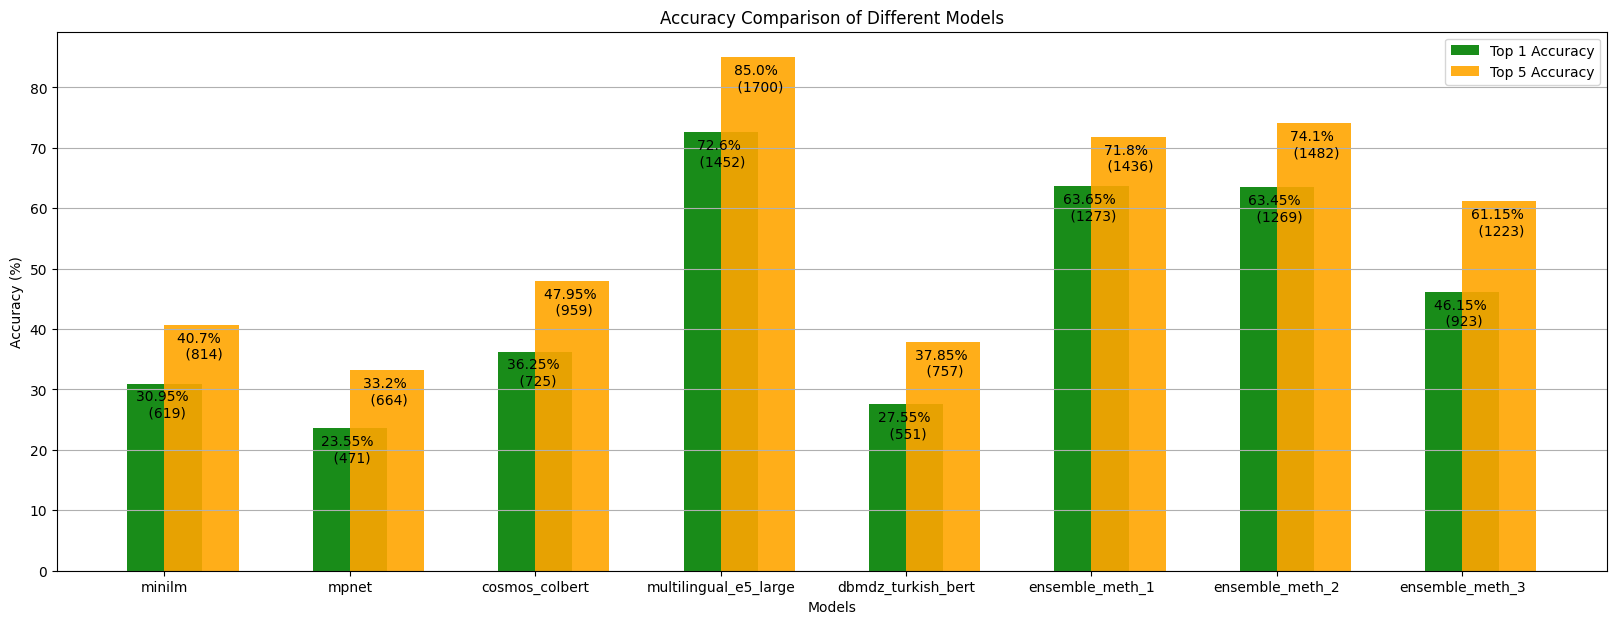

In [40]:
accuracy_dictionary['ensemble_meth_1'] = calculate_accuracy(
    ensemble_top5_indexes_and_similarities_dictionary_method_1)
accuracy_dictionary['ensemble_meth_2'] = calculate_accuracy(
    ensemble_top5_indexes_and_similarities_dictionary_method_2)
accuracy_dictionary['ensemble_meth_3'] = calculate_accuracy(
    ensemble_top5_indexes_and_similarities_dictionary_method_3)
plot_accuracies(accuracy_dictionary)

# Sonuçlar

- multilingual-e5-large-instruct modeli en iyi sonucu vermiştir.
- Diğer modellerin başarı sırasına göre dizilimi aşağıdaki gibi:
  - ytu-ce-cosmos/turkish-colbert
  - all-MiniLM-L12-v2
  - bert-base-turkish-cased
  - all-mpnet-base-v2

* Ensemble başarılarının en iyi olduğu model multilingual-e5-large-instruct dan daha düşük çıktığı görülmüştür.
  - Bunun nedeninin diğer modellerin ortalama başarısının %40 civarlarında olması nedeniyle kollektif başarıyı düşürmesine bağlayabiliriz.
  - Ensemble kararı üzerinde diğer modellerin verdiği ortak kararında etkisi olduğu için ortak karar başarısı düşük çıkmıştır.

# Feature Work

- Ensenmble metodları standart olarak kullanılan (Majority Voting, Border Count, Mean Ensemble, Rank Aggregation, Weighted Voting) metodlar olarak düzenlenebilir. Veya zaten bunlardan biriyse ismi bu olarak değiştirilebilir.
  - Ensemble Method 1: Majority Voting oluyor.
  - Ensemble Method 2:
  - Ensemble Method 3:
  - Democracy Voting:
  - Avarage Similarity Ensemble, Mean Ensemble
  - Max Similarity Ensemble
  - Democracy Ensemble, Majority Voting Ensemble
  - Border Count Ensemble
  - Rank Aggregation Ensemble
  - Weighted Voting Ensemble
- Yukarıda sunulan sonuçların gerçekten doğruluğunun anlaşılabilmesi için en başarılı olan modelin çıkarılarak diğer 4 modelin başarısı ölçümlenebilirdi.
- Bu durumda kollektif başarının ne olduğuna bakarsak aslında yukarıda sunduğumuz hipotezin doğru olup olmadığına karar verebiliriz.
- Yukarıdaki denemeler modellerin embedding leri çıkarma süresinin 2000 örnek için 2 saatten fazla sürmesi nedeniyle yapılamamıştır.


# Referanslar

- [IBM Technology - What is Retrieval-Augmented Generation (RAG)?](https://www.youtube.com/watch?v=T-D1OfcDW1M)
- [Advanced RAG: Ensemble Retrieval](https://www.youtube.com/watch?v=s2i4zeWjUtM)
- [Advanced RAG 01 - Self Querying Retrieval](https://www.youtube.com/watch?v=f4LeWlt3T8Y)
- https://huggingface.co/datasets/merve/turkish_instructions
- [all-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L12-v2)
- [all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2)
- [ytu-ce-cosmos/turkish-colbert](https://huggingface.co/ytu-ce-cosmos/turkish-colbert)
- [Multilingual-E5-large-instruct](https://huggingface.co/intfloat/multilingual-e5-large-instruct)
- [dbmdz Turkish BERT model](https://huggingface.co/dbmdz/bert-base-turkish-cased)
-
